# **CS224W - Colab 3**

In Colab 2 we constructed GNN models by using PyTorch Geometric's built in GCN layer, `GCNConv`. In this Colab we will go a step deeper and implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

## Installation

In [1]:
# # Install torch geometric
# import os
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#   !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
#   !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
#   !pip install torch-geometric
#   !pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [2]:
import torch_geometric
torch_geometric.__version__

'2.2.0'

# 1) GNN Layers

## Implementing Layer Modules

In Colab 2, we implemented a GCN model for node and graph classification tasks. However, for that notebook we took advantage of PyG's built in GCN module. For Colab 3, we provide a build upon a general Graph Neural Network Stack, into which we will be able to plugin our own module implementations: GraphSAGE and GAT.

We will then use our layer implemenations to complete node classification on the CORA dataset, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node. 

## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** and **GAT** (Colab 4) layers will function as components in the GNNStack Module.

In [3]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

In [4]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, you need to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Creating Our Own Message Passing Layer

To do so, we will work with and implement 3 critcal functions needed to define a PyG Message Passing Layer: `forward`, `message`, and `aggregate`.

The job of a message passing layer is to update the current feature representation or embedding of each node in a graph by propagating and transforming information within the graph. Overall, the general paradigm of a message passing layers is: 1) pre-processing -> 2) **message passing** / propagation -> 3) post-processing. 

The `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function. 

The `propagate` function encapsulates the message passing process! It does so by calling three important functions: 1) `message`, 2) `aggregate`, and 3) `update`. Our implementation will vary slightly from this, as we will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing), we can further transform the node embeddings outputed by `propagate`. Therefore, the output of `forward` is exactly the node embeddings after one GNN layer.


```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
This function belongs to the base class MessagePassing.
Calling `propagate` initiates the message passing process.

  - `edge_index` 
  - `x=(x_i, x_j)`. x_i is the central node feature (embedding) and x_j is the neighboring node feature (embedding). 
  - `extra=(extra_i, extra_j)` represents additional information that we can associate with each node beyond its current feature embedding.

  The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $[N, d]$.




For additional resources refer to the PyG documentation for implementing custom message passing layers: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

## GraphSage Implementation

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows: 

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

Additionally, we use mean aggregation for simplicity:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we're adding a **skip connection** to our GraphSage implementation through the term $W_l\cdot h_v^{(l-1)}$. 

Note: Remember that the `propagate` function encapsulates the operations of / the outputs of the combined `message` and `aggregate` functions.


Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.

In [9]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):

        out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + out
        if self.normalize:
            out = F.normalize(out, p=2, dim=1)

        return out

    def message(self, x_j):
        """
        Called by `propagate` and constructs the messages from neighboring nodes $j$ to central nodes $i$ 
        for each edge $(i, j)$ in *edge_index*. This function can take any argument that was initially 
        passed to `propagate`.
        
        Args:
            x_j: represents a matrix of feature embeddings for all neighboring nodes passing their messages 
            along their respective edge (i.e. all nodes $j$ for edges $(i, j) \in \mathcal{E}$). 
            Thus, its shape is $[|\mathcal{E}|, d]$!
        Returns:
            out: a matrix of neighboring node embeddings ready to be aggregated, having shape $[|\mathcal{E}|, d]$.
        """

        out = self.lin_r(x_j)
        return out

    def aggregate(self, inputs, index, dim_size = None):
        """
        Aggregate the messages from neighboring nodes.
        Args:
            inputs: represents a matrix of the messages passed from neighboring nodes 
            (i.e. the output of the `message` function).
            index: has the same shape as `inputs` in the first dimension and tells us the central node that 
            corresponding to each of the rows / messages $j$ in the `inputs` matrix. 
            Thus, `index` tells us which rows / messages to aggregate for each central node.
        Returns:
            out: the aggregated messages for each central node, shape $[N, d]$.
        """

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')

        return out


## Building Optimizers

In [10]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

In [13]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

Node task. test set size: 1000



/home/hujunhao/.conda/envs/GNN/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training: 100%|██████████| 500/500 [08:02<00:00,  1.04Epochs/s]  


Maximum test set accuracy: 0.796
Minimum loss: 0.10269097238779068
Saving Model Predictions for Model Type GraphSage



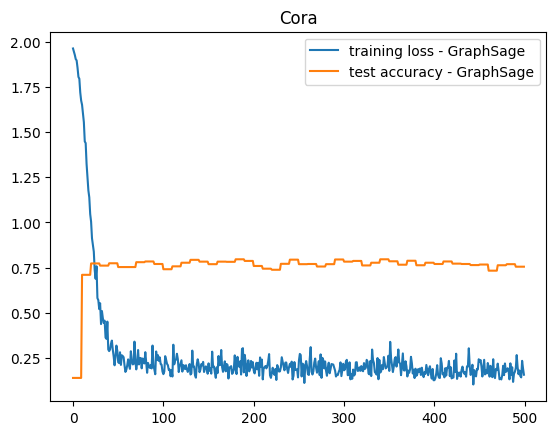

In [17]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


## Question 1.1: What is the maximum accuracy obtained on the test set for GraphSage? (10 points)

Running the cell above will show the results of your best model and save your best model's predictions to a file named *CORA-Node-GraphSage.csv*.  